<a href="https://colab.research.google.com/github/mabonmn/Video_Summerization_knapsack/blob/main/P4_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports/Module setup
Pip Install Ortools

> Reset Runtime after this section for pip install



In [ ]:
!pip install ortools

Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import h5py
import math
import numpy as np
from ortools.algorithms import pywrapknapsack_solver
import os


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# H5 File Load

In [ ]:
tvsum_h5_eccv= h5py.File('/content/drive/MyDrive/Feature Extraction - Mabon/frame_score-P4/Knapsack_visualisation-1/h5/tvsum_change_points_eccv.h5', 'r')
tvsum_cp_y= h5py.File('/content/drive/MyDrive/Feature Extraction - Mabon/frame_score-P4/Knapsack_visualisation-1/h5/tvsum_change_points_yahoo.h5', 'r')
tvsum_cp_j= h5py.File('/content/drive/MyDrive/Feature Extraction - Mabon/frame_score-P4/Knapsack_visualisation-1/h5/tvsum_change_points_jeshmitha_updated.h5', 'r')
tvsum_cp_u= h5py.File('/content/drive/MyDrive/Feature Extraction - Mabon/frame_score-P4/Knapsack_visualisation-1/h5/tvsum_change_points_uniform_updated.h5', 'r')
excel_path=('/content/drive/MyDrive/Feature Extraction - Mabon/frame_score-P4/Knapsack_visualisation-1/TvSum.xlsx')


# Simple plots (H5-ECCV)



Structure of the h5:
array(['change_points', 'features', 'gtscore', 'gtsummary',
       'n_frame_per_seg', 'n_frames', 'n_steps', 'picks', 'user_summary'])
Structure of H5 File does not affect the running of this code. As long as the attributes are labeled the same as given above the code will automaticall sort the data into the resective variables. If the names diffe compared to any of the above, please change the variable in "tvsum_h5_eccv['video_'+str(v)]['CHANGE'][:]"


1.   Change Point:(71*2:Not Downsampled) The begining and end of each shot in the video. We use change_pts.shape[0] to get the total number of segments in the video
2.   Features:(707*1024:Downsampled) Features Extracted from models such as GoogLeNet (For the purpose of this code this is not required)
3.   gtscore(ground truce score):(707,1:Downsampled)
4.   gtsummary:(summary Standard)(707,1:Downsampled)
5.   n_frame_per_seg:(71*1:Not Downsampled)Number of Frames in each segment of the video ( A segment is serie of shots)
6.   n_frames:(Int)Original number of frames
7.   n_steps
8.   picks: (707:Downsampled)
9.   user_summary:(20 annotater user summary)(20*10597: Not Downsampled) val either 0 or 1 to indicate if the frame has been picked for the summart.



---


For this code to run we require the number of frames, gt_scores,change points, frames per seg and the user summary 

##H5 File Structure

In [ ]:
file_load_structure=h5py.File('/content/drive/MyDrive/Feature Extraction - Mabon/frame_score-P4/Knapsack_visualisation-1/h5/tvsum_change_points_eccv.h5', 'r')
with file_load_structure as hdf:
  ky1=np.array(list(hdf.keys()))
  g1=hdf.get(ky1[1])
  g1_item_1=np.array(list(g1.keys()))
  hdf.close()
print("Main Keys: ")
print(ky1)
print("Sub Keys:  ")
print(g1_item_1)

Main Keys: 
['video_1' 'video_10' 'video_11' 'video_12' 'video_13' 'video_14'
 'video_15' 'video_16' 'video_17' 'video_18' 'video_19' 'video_2'
 'video_20' 'video_21' 'video_22' 'video_23' 'video_24' 'video_25'
 'video_26' 'video_27' 'video_28' 'video_29' 'video_3' 'video_30'
 'video_31' 'video_32' 'video_33' 'video_34' 'video_35' 'video_36'
 'video_37' 'video_38' 'video_39' 'video_4' 'video_40' 'video_41'
 'video_42' 'video_43' 'video_44' 'video_45' 'video_46' 'video_47'
 'video_48' 'video_49' 'video_5' 'video_50' 'video_6' 'video_7' 'video_8'
 'video_9']
Sub Keys:  
['change_points' 'features' 'gtscore' 'gtsummary' 'n_frame_per_seg'
 'n_frames' 'n_steps' 'picks' 'user_summary']


In [ ]:
#Video Number
v=1
#User Number
#Change the user number to view the differnt summerizations
user=15
##note: i would recomemd using video 45 which is relitavely short and therfore eaiser to understand the plot

In [ ]:
#Load the h5 File here.
#we also require the excel file with the frame scores.
file_load=h5py.File('/content/drive/MyDrive/Feature Extraction - Mabon/frame_score-P4/Knapsack_visualisation-1/h5/tvsum_change_points_eccv.h5', 'r')

tvsum_raw=pd.read_excel(excel_path, header=None, sheet_name=str(v)) 

In [ ]:
#Load the Data from the H5 File
#some data that are not required are not loaded.

#picks=file_load['video_'+str(v)]['picks'][:]
n_frame=file_load['video_'+str(v)]['n_frames'][()]
#change_pts=file_load['video_'+str(v)]['change_points'][:]
#nfps=file_load['video_'+str(v)]['n_frame_per_seg'][:]
#gt_score=file_load['video_'+str(v)]['gtscore'][:]
#gt_summary=file_load['video_'+str(v)]['gtsummary'][:]
#user_summary=file_load['video_'+str(v)]['user_summary'][:]
gt=tvsum_raw.mean(axis='columns')
user_summary_selected=file_load['video_'+str(v)]['user_summary'][:][user]

Use this cell to generate sample test Data to use. (optinal: we can use the colab "data_gen_test" to do the same and load this onto a h5 file) 

In [ ]:
'''
'''
'''
#frame score
gt = np.random.randint(1, 5,50)
gt = pd.DataFrame(gt)
#number of frames
n_frame=len(gt)
#pick points every 10 frames
picks=[1,34]
picks=np.array(picks)
#Change Points
change_pts = [[    0,    11],
       [   12,    19],
       [   20,   29],
       [  30,   45],
       [  46,   49]]
change_pts=np.array(change_pts)
#User summ
user_summary = [1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0]
user_summary=np.array(user_summary)
nfps=[12,8,10,16,4]
nfps=np.array(nfps)
'''
'''
'''

'\n'

In [ ]:
def frame_seg(change_pts,nfps,gt):
  
  '''
  This is a simple function that is used to calculate the frame segment score based on the gt score.
  here segment scores are taken as the mean of all the frame_scores (gt) in that shot. 
  Inputs:
    change_pts: Change Points -> list
    nfps:Number of Frames in each segment  -> list
    gt:gt score -> list

  --------------------------------------------------------------------------------------------------------------------------------------------------------
  Data Types in the funtion  
    n_seg: Number Of segments in the video
    seg_score: Vector conting the mean scores of the frames in each segment. 
    frame_seg_score: a vector containg all the frame scores from segments scoress. ie we take segment 1' score and assin this score to all the frames in that segment.

  ---------------------------------------------------------------------------------------------------------------------------------------------------------
  Output
    seg_score : Segment score list ->list
    frame_seg_score: average score of frames based on the segement score  -> list
  '''
  n_segs = change_pts.shape[0]
  seg_score = []
  for seg_idx in range(n_segs):
      start, end = int(change_pts[seg_idx,0]), int(change_pts[seg_idx,1]+1)
      scores = gt[start:end]
      seg_score.append(float(scores.mean()))
  frame_seg_score=[]
  for seg_idx in range(n_segs):
      nf = nfps[seg_idx]
      frame_seg_score.extend([seg_score[seg_idx] for i in range(nf)])
  return seg_score,frame_seg_score 

In [ ]:
#This funtion is used to define the color sequnce for the KV- bar plot

def color_coding(summary):

#input of this is the summary and the list of colors for each of the points in the summary is returned.
  c=[]
  for x in summary:
    if x==0:
      c.append('red')
    elif x==1:
      c.append('green')

  return c

In [ ]:
#file_load['video_'+str(1)]['change_points'].info()

In [ ]:
seg_score,frame_seg=frame_seg(file_load['video_'+str(v)]['change_points'][:],file_load['video_'+str(v)]['n_frame_per_seg'][:],gt)

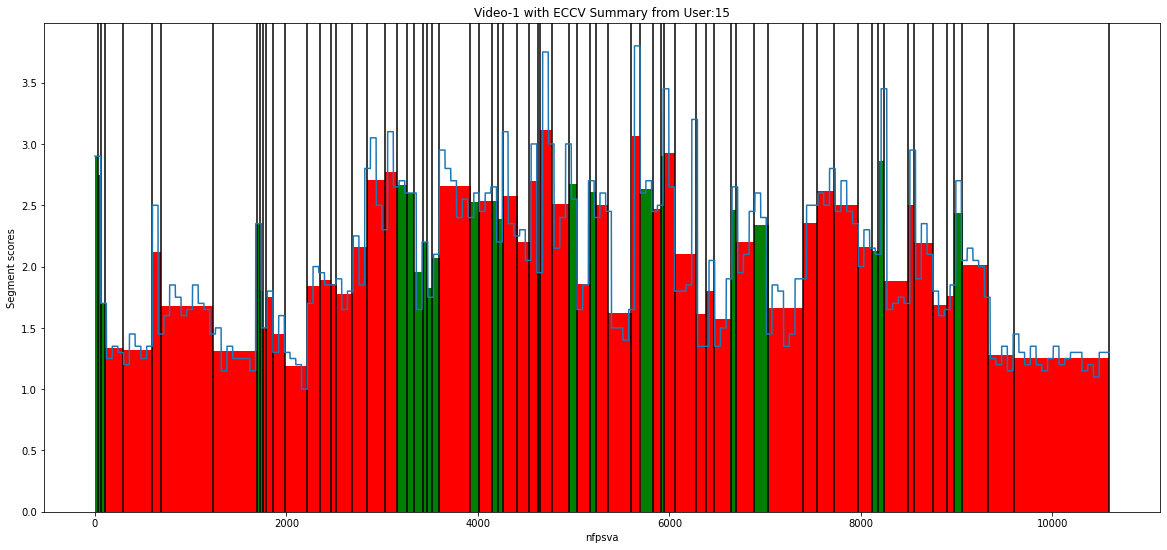

<Figure size 432x288 with 0 Axes>

In [ ]:
#The first plot contains the following information:
#Creating the figure to plot on. 

fig = plt.figure(figsize = (20, 9))

plt.bar(x=list(range(1, n_frame+1)), height=frame_seg, width=1,color=color_coding(file_load['video_'+str(v)]['user_summary'][:][user]))

# plt.bar(x=list(range(1, n_frame+1)), height=frame_seg, width=1,color=color_coding(user_summary)): USe this for sample points. single user mode

#Ploting the Segments on the figure (Each line is used to represent a segment from the vidoe)
for s in file_load['video_'+str(v)]['change_points'][:]:
  plt.axvline(x=s[1], color='black')


#ploting the gtscore for each frame through the course of the vidoe 

plt.plot(list(range(0, n_frame)), gt)

#Labels
plt.xlabel("nfpsva")
plt.ylabel("Segment scores")
plt.title("Video-"+str(v)+" with ECCV Summary from User:"+str(user))

plt.show()
plt.clf()

In [ ]:
def classify2(seg_score,nfps,n_frame,user_summary_selected):
  '''
  This is a simple function that is used create 4 arrayS which contain the number of frames and score of the selected and unslected segments based on the user summary.

  Inputs:
    seg_score: Change Points               -> list
    n_frame : number of frames in the video -> int
    nfps:Number of Frames in each segment  -> list
    user_summary_selected:Selected user summary -> list
  ---------------------------------------------------------------------------------------------------------------------------------------------------------
  Output
    selected:  Selected points (representing segment score) based on usersummary     -> list
    seg_score_selected : Segment score of selected points ->list
    unselected:UnSelected points based on picks from h5 file   -> list
    seg_score_unselected : Segment score of Unselected points ->list
  '''
  selected=[]
  seg_score_selected=[]
  unselected=[]
  seg_score_unselected=[]
  i=0
  seg_no=0
  while (i<n_frame):

    seg_no=seg_no+1
    
    if(user_summary_selected[i]==1):
      seg_score_selected.append(seg_score[seg_no-1])
      selected.append(nfps[seg_no-1])
      i=i+nfps[seg_no-1]
    
    
    else:
      seg_score_unselected.append(seg_score[seg_no-1])
      unselected.append(nfps[seg_no-1])
      i=i+nfps[seg_no-1]
  
  return selected, unselected,seg_score_selected,seg_score_unselected,

In [ ]:
selected,unselected,seg_score_selected,seg_score_unselected=classify2(seg_score,file_load['video_'+str(v)]['n_frame_per_seg'][:],n_frame,user_summary_selected)
sse=sorted(seg_score)
sle=sorted(file_load['video_'+str(v)]['n_frame_per_seg'][:])

'''
numpy.percentile(a, q, axis=None, out=None, overwrite_input=False, method='linear', keepdims=False, *, interpolation=None)[source]
Compute the q-th percentile of the data along the specified axis.

Returns the q-th percentile(s) of the array elements.
'''

p=[0,10, 20, 30, 40, 50, 60, 70, 80, 90]
rse=np.percentile(sse, p)[1:]
rle=np.percentile(sle, p)[1:]


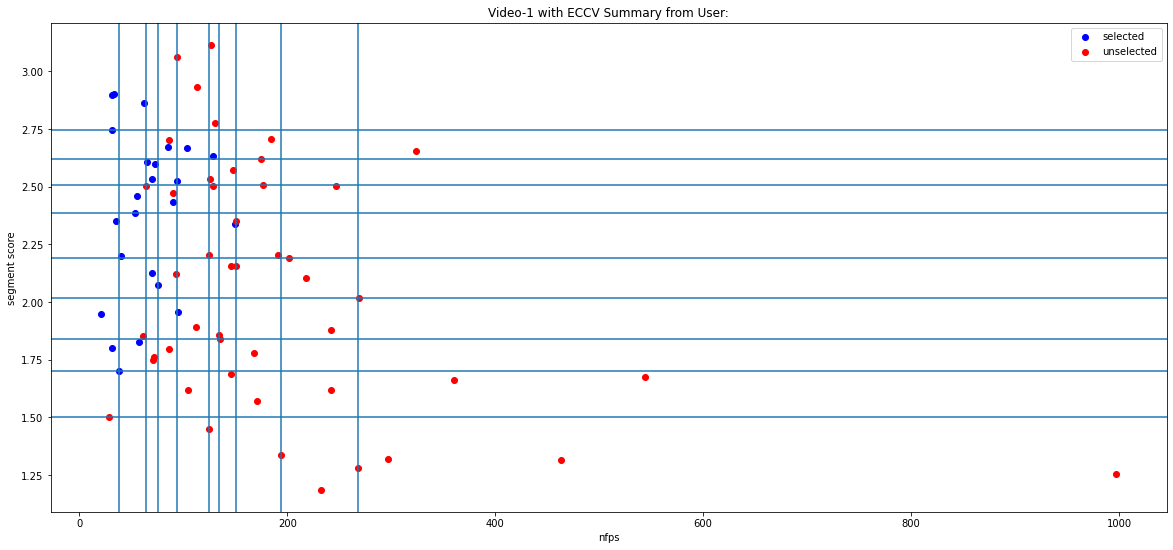

<Figure size 432x288 with 0 Axes>

In [ ]:
#Plotting the figure: 
# The following grapah is used to represent the segments of thhe videos that are selected for the final summary of the video.
# The Blue points are used to represent the points that are selected and the red those that are not seleced for hte final summary.
# The horizonatal lines are used to represent the percentiles of the segment score 
# The Vertical lines are used to represent the percentiles of the number of frames per segment

fig = plt.figure(figsize = (20, 9))

plt.scatter(selected,seg_score_selected, color='blue', label='selected')
plt.scatter(unselected,seg_score_unselected, color='red', label='unselected')


for yi in rse:
  plt.axhline(y = yi, linestyle = '-')
for xi in rle:
  plt.axvline(x = xi, linestyle = '-')


plt.xlabel('nfps')
plt.ylabel('segment score')
plt.legend()
plt.title("Video-"+str(v)+" with ECCV Summary from User:")
plt.show()
#plt.savefig("ECCV/"+str(v)+".png")
plt.clf()

# Folder to save Graphs(run only if you want to save plots)

In [ ]:
'''
path='/content/temp'
isExists = os.path.exists(path)
if not isExists:
  os.makedirs(path)
else:
  print(" Directory already exists")
path=path+'/'
isExists = os.path.exists(path+"ECCV")
if not isExists:
  os.makedirs(path+"ECCV")
else:
  print(" Directory already exists")
isExists = os.path.exists(path+"New")
if not isExists:
  os.makedirs(path+"New")
else:
  print(" Directory already exists")
isExists = os.path.exists(path+"Uniform")
if not isExists:
  os.makedirs(path+"Uniform")
else:
  print(" Directory already exists")
isExists = os.path.exists(path+"Yahoo")
if not isExists:
  os.makedirs(path+"Yahoo")
else:
  print(" Directory already exists")
  '''

'\npath=\'/content/temp\'\nisExists = os.path.exists(path)\nif not isExists:\n  os.makedirs(path)\nelse:\n  print(" Directory already exists")\npath=path+\'/\'\nisExists = os.path.exists(path+"ECCV")\nif not isExists:\n  os.makedirs(path+"ECCV")\nelse:\n  print(" Directory already exists")\nisExists = os.path.exists(path+"New")\nif not isExists:\n  os.makedirs(path+"New")\nelse:\n  print(" Directory already exists")\nisExists = os.path.exists(path+"Uniform")\nif not isExists:\n  os.makedirs(path+"Uniform")\nelse:\n  print(" Directory already exists")\nisExists = os.path.exists(path+"Yahoo")\nif not isExists:\n  os.makedirs(path+"Yahoo")\nelse:\n  print(" Directory already exists")\n  '

# Knapsack

In [ ]:

#===========================================
'''
------------------------------------------------
Use dynamic programming (DP) to solve 0/1 knapsack problem
Time complexity: O(nW), where n is number of items and W is capacity

Author: Kaiyang Zhou
Website: https://kaiyangzhou.github.io/
------------------------------------------------
knapsack_dp(values,weights,n_items,capacity,return_all=False)

Input arguments:
  1. values: a list of numbers in either int or float, specifying the values of items
  2. weights: a list of int numbers specifying weights of items
  3. n_items: an int number indicating number of items
  4. capacity: an int number indicating the knapsack capacity
  5. return_all: whether return all info, defaulty is False (optional)

Return:
  1. picks: a list of numbers storing the positions of selected items
  2. max_val: maximum value (optional)
------------------------------------------------
'''
def knapsack_dp(values,weights,n_items,capacity,return_all=False):
    check_inputs(values,weights,n_items,capacity)

    table = np.zeros((n_items+1,capacity+1),dtype=np.float32)
    keep = np.zeros((n_items+1,capacity+1),dtype=np.float32)

    for i in range(1,n_items+1):
        for w in range(0,capacity+1):
            wi = weights[i-1] # weight of current item
            vi = values[i-1] # value of current item
            if (wi <= w) and (vi + table[i-1,w-wi] > table[i-1,w]):
                table[i,w] = vi + table[i-1,w-wi]
                keep[i,w] = 1
            else:
                table[i,w] = table[i-1,w]

    picks = []
    K = capacity

    for i in range(n_items,0,-1):
        if keep[i,K] == 1:
            picks.append(i)
            K -= weights[i-1]

    picks.sort()
    picks = [x-1 for x in picks] # change to 0-index

    if return_all:
        max_val = table[n_items,capacity]
        return picks,max_val
    return picks







In [ ]:
#This function is to ensure that  the values are passed to the function in the appropriate data-type. 
#It also ensure that the inputed values are in the correct range.

def check_inputs(values,weights,n_items,capacity):
    # check variable type
    assert(isinstance(values,list))
    assert(isinstance(weights,list))
    assert(isinstance(n_items,int))
    assert(isinstance(capacity,int))
    # check value type
    assert(all(isinstance(val,int) or isinstance(val,float) for val in values))
    assert(all(isinstance(val,int) for val in weights))
    # check validity of value
    assert(all(val >= 0 for val in weights))
    assert(n_items > 0)
    assert(capacity > 0)

In [ ]:

osolver = pywrapknapsack_solver.KnapsackSolver(
    # pywrapknapsack_solver.KnapsackSolver.KNAPSACK_MULTIDIMENSION_BRANCH_AND_BOUND_SOLVER,
    pywrapknapsack_solver.KnapsackSolver.KNAPSACK_DYNAMIC_PROGRAMMING_SOLVER,
    'test')


In [ ]:
def knapsack_ortools(values, weights, items, capacity ):
    scale = 1000
    values = np.array(values)
    weights = np.array(weights)
    values = (values * scale).astype(np.int)
    weights = (weights).astype(np.int)
    capacity = capacity

    osolver.Init(values.tolist(), [weights.tolist()], [capacity])
    computed_value = osolver.Solve()
    packed_items = [x for x in range(0, len(weights))
                    if osolver.BestSolutionContains(x)]

    return packed_items



# KV-1 (Segment Score V/s Frames Plots)



In [ ]:
# This function generates and returns a segment score summary vectore and a vector containing the selected points.
def generate_summary(ypred, cps, n_frames, nfps, positions, proportion=0.15, method='knapsack'):
    """Generate keyshot-based video summary i.e. a binary vector.
    Args:
    ---------------------------------------------
    - ypred: predicted importance scores.
    - cps: change points, 2D matrix, each row contains a segment.
    - n_frames: original number of frames.
    - nfps: number of frames per segment.
    - positions: positions of subsampled frames in the original video.
    - proportion: length of video summary (compared to original video length).
    - method: defines how shots are selected, ['knapsack', 'rank'].
    """
    n_segs = cps.shape[0]
    frame_scores = np.zeros((n_frames), dtype=np.float32)
    if positions.dtype != int:
        positions = positions.astype(np.int32)
    if positions[-1] != n_frames:
        positions = np.concatenate([positions, [n_frames]])
    if len(ypred)==n_frames:
      frame_scores=ypred
    elif len(ypred)==len(positions):
      for i in range(len(positions) - 1):
        pos_left, pos_right = positions[i], positions[i+1]
        if i == len(ypred):
            frame_scores[pos_left:pos_right] = 0
        else:
            frame_scores[pos_left:pos_right] = ypred[i]
    else:
      print("check the length of frame scores")

    seg_score = []
    for seg_idx in range(n_segs):
        start, end = int(cps[seg_idx,0]), int(cps[seg_idx,1]+1)
        scores = frame_scores[start:end]
        seg_score.append(float(scores.mean()))

    limits = int(math.floor(n_frames * proportion))

    if method == 'knapsack':
        #picks = knapsack_dp(seg_score, nfps, n_segs, limits)
        picks = knapsack_ortools(seg_score, nfps, n_segs, limits)
    elif method == 'rank':
        order = np.argsort(seg_score)[::-1].tolist()
        picks = []
        total_len = 0
        for i in order:
            if total_len + nfps[i] < limits:
                picks.append(i)
                total_len += nfps[i]
    else:
        raise KeyError("Unknown method {}".format(method))


    return seg_score, picks


In [ ]:
def classify(seg_score, nfps, picks):

  selected={'seg_score':[], 'nfps':[]}
  unselected={'seg_score':[], 'nfps':[]}

  n_segs=len(seg_score)
  for s in range(n_segs):
    if s in picks:
      selected['seg_score'].append(seg_score[s])
      selected['nfps'].append(nfps[s])
    else:
      unselected['seg_score'].append(seg_score[s])
      unselected['nfps'].append(nfps[s])

  return selected, unselected

In [ ]:

tvsum_raw=pd.read_excel(excel_path, header=None, sheet_name=str(v)) 
gt=tvsum_raw.mean(axis='columns')

p=tvsum_h5_eccv['video_'+str(v)]['picks'][:]
nf=tvsum_h5_eccv['video_'+str(v)]['n_frames'][()]


cp_e=tvsum_h5_eccv['video_'+str(v)]['change_points'][:]
cp_y=tvsum_cp_y['video_'+str(v)][:]
cp_j=tvsum_cp_j['video_'+str(v)][:]
cp_u=tvsum_cp_u['video_'+str(v)][:]
nfps_e=tvsum_h5_eccv['video_'+str(v)]['n_frame_per_seg'][:]
nfps_y=[]
nfps_j=[]
nfps_u=[]

for y in cp_y:
  nfps_y.append(y[1]-y[0]+1)
nfps_y=np.array(nfps_y)

for j in cp_j:
  nfps_j.append(j[1]-j[0]+1)
nfps_j=np.array(nfps_j)

for u in cp_u:
  nfps_u.append(u[1]-u[0]+1)
nfps_u=np.array(nfps_u)

seg_score_e, picks_e=generate_summary(gt, cp_e, nf, nfps_e, p)
seg_score_y, picks_y=generate_summary(gt, cp_y, nf, nfps_y, p)
seg_score_j, picks_j=generate_summary(gt, cp_j, nf, nfps_j, p)
seg_score_u, picks_u=generate_summary(gt, cp_u, nf, nfps_u, p)

selected_e, unselected_e = classify(seg_score_e, nfps_e, picks_e)
selected_y, unselected_y = classify(seg_score_y, nfps_y, picks_y)
selected_j, unselected_j = classify(seg_score_j, nfps_j, picks_j)
selected_u, unselected_u = classify(seg_score_u, nfps_u, picks_u)

sse=sorted(seg_score_e)
ssy=sorted(seg_score_y)
ssj=sorted(seg_score_j)
ssu=sorted(seg_score_u)

sle=sorted(nfps_e)
sly=sorted(nfps_y)
slj=sorted(nfps_j)
slu=sorted(nfps_u)

p=[0,10, 20, 30, 40, 50, 60, 70, 80, 90]

rse=np.percentile(sse, p)[1:]
rsy=np.percentile(ssy, p)[1:]
rsj=np.percentile(ssj, p)[1:]
rsu=np.percentile(ssu, p)[1:]

rle=np.percentile(sle, p)[1:]
rly=np.percentile(sly, p)[1:]
rlj=np.percentile(slj, p)[1:]
rlu=np.percentile(slu, p)[1:]





/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Depr

# Plots- KV1




> ECCV






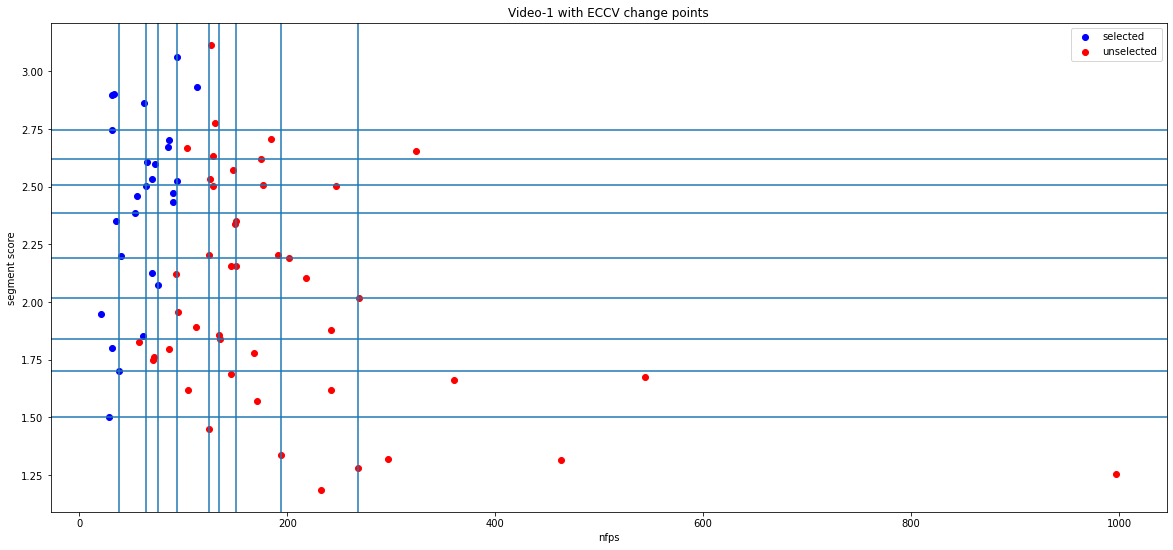

<Figure size 432x288 with 0 Axes>

In [ ]:
fig = plt.figure(figsize = (20, 9))
plt.scatter(selected_e['nfps'],selected_e['seg_score'], color='blue', label='selected')
plt.scatter(unselected_e['nfps'],unselected_e['seg_score'], color='red', label='unselected')
for yi in rse:
  plt.axhline(y = yi, linestyle = '-')
for xi in rle:
  plt.axvline(x = xi, linestyle = '-')
plt.xlabel('nfps')
plt.ylabel('segment score')
plt.legend()
plt.title("Video-"+str(v)+" with ECCV change points")
plt.show()
#plt.savefig("ECCV/"+str(v)+".png")
plt.clf()



> Yahoo



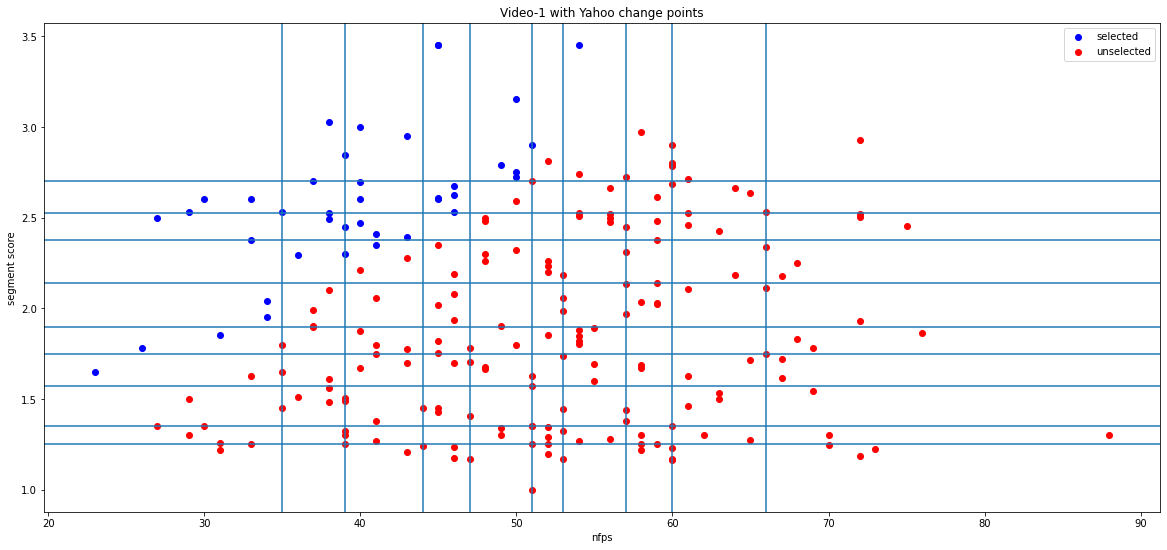

<Figure size 432x288 with 0 Axes>

In [ ]:
fig = plt.figure(figsize = (20, 9))
plt.scatter(selected_y['nfps'],selected_y['seg_score'], color='blue', label='selected')
plt.scatter(unselected_y['nfps'],unselected_y['seg_score'], color='red', label='unselected')
for yi in rsy:
  plt.axhline(y = yi, linestyle = '-')
for xi in rly:
  plt.axvline(x = xi, linestyle = '-')
plt.xlabel('nfps')
plt.ylabel('segment score')
plt.legend()
plt.title("Video-"+str(v)+" with Yahoo change points")
plt.show()
#plt.savefig("Yahoo/"+str(v)+".png")
plt.clf()



> New



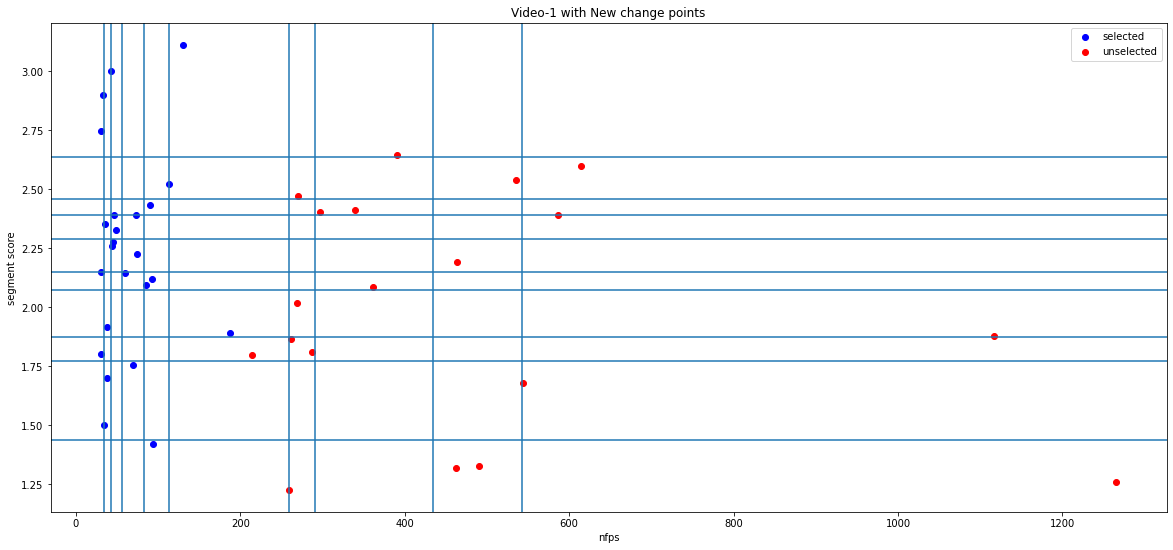

<Figure size 432x288 with 0 Axes>

In [ ]:
fig = plt.figure(figsize = (20, 9))
plt.scatter(selected_j['nfps'],selected_j['seg_score'], color='blue', label='selected')
plt.scatter(unselected_j['nfps'],unselected_j['seg_score'], color='red', label='unselected')
for yi in rsj:
  plt.axhline(y = yi, linestyle = '-')
for xi in rlj:
  plt.axvline(x = xi, linestyle = '-')
plt.xlabel('nfps')
plt.ylabel('segment score')
plt.legend()
plt.title("Video-"+str(v)+" with New change points")
plt.show()
#plt.savefig("New/"+str(v)+".png")
plt.clf()



> Uniform




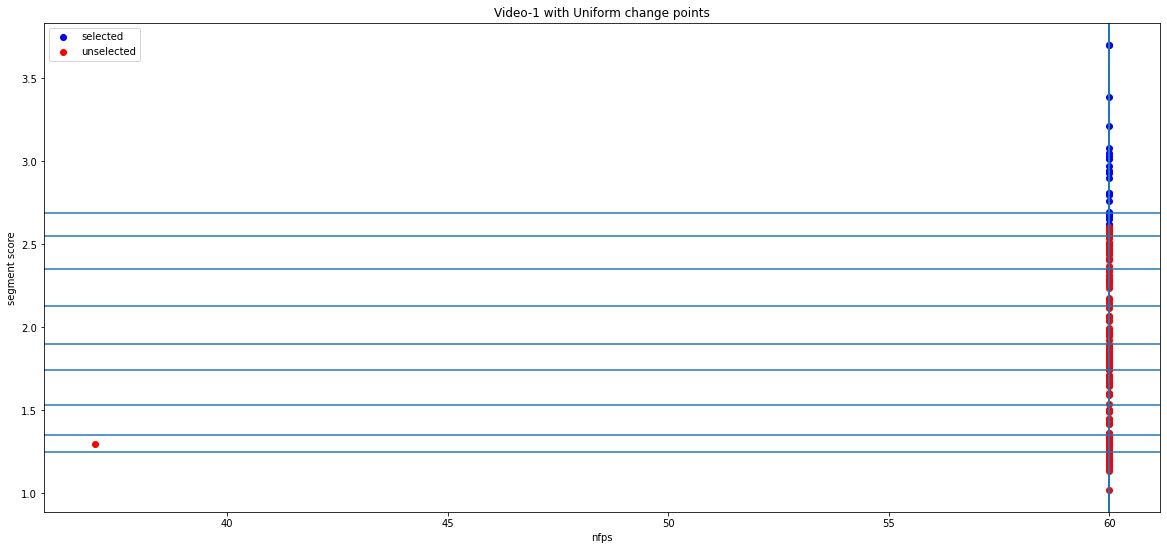

<Figure size 432x288 with 0 Axes>

In [ ]:
fig = plt.figure(figsize = (20, 9))
plt.scatter(selected_u['nfps'],selected_u['seg_score'], color='blue', label='selected')
plt.scatter(unselected_u['nfps'],unselected_u['seg_score'], color='red', label='unselected')
for yi in rsu:
  plt.axhline(y = yi, linestyle = '-')
for xi in rlu:
  plt.axvline(x = xi, linestyle = '-')
plt.xlabel('nfps')
plt.ylabel('segment score')
plt.legend()
plt.title("Video-"+str(v)+" with Uniform change points")
plt.show()
#plt.savefig("Uniform/"+str(v)+".png")
plt.clf()

# KV-2 (Frame Score V/s Frame Plots)

In [ ]:

def generate_summary2(ypred, cps, n_frames, nfps, positions, proportion=0.15, method='knapsack'):
    """Generate keyshot-based video summary i.e. a binary vector.
    Args:
    ---------------------------------------------
    - ypred: predicted importance scores.
    - cps: change points, 2D matrix, each row contains a segment.
    - n_frames: original number of frames.
    - nfps: number of frames per segment.
    - positions: positions of subsampled frames in the original video.
    - proportion: length of video summary (compared to original video length).
    - method: defines how shots are selected, ['knapsack', 'rank'].
    """
    n_segs = cps.shape[0]
    frame_scores = np.zeros((n_frames), dtype=np.float32)
    if positions.dtype != int:
        positions = positions.astype(np.int32)
    if positions[-1] != n_frames:
        positions = np.concatenate([positions, [n_frames]])
    if len(ypred)==n_frames:
      frame_scores=ypred
    elif len(ypred)==len(positions):
      for i in range(len(positions) - 1):
        pos_left, pos_right = positions[i], positions[i+1]
        if i == len(ypred):
            frame_scores[pos_left:pos_right] = 0
        else:
            frame_scores[pos_left:pos_right] = ypred[i]
    else:
      print("check the length of frame scores")

    seg_score = []
    for seg_idx in range(n_segs):
        start, end = int(cps[seg_idx,0]), int(cps[seg_idx,1]+1)
        scores = frame_scores[start:end]
        seg_score.append(float(scores.mean()))

    limits = int(math.floor(n_frames * proportion))

    if method == 'knapsack':
        #picks = knapsack_dp(seg_score, nfps, n_segs, limits)
        picks = knapsack_ortools(seg_score, nfps, n_segs, limits)
    elif method == 'rank':
        order = np.argsort(seg_score)[::-1].tolist()
        picks = []
        total_len = 0
        for i in order:
            if total_len + nfps[i] < limits:
                picks.append(i)
                total_len += nfps[i]
    else:
        raise KeyError("Unknown method {}".format(method))

    summary = np.zeros((1), dtype=np.float32) # this element should be deleted
    for seg_idx in range(n_segs):
        nf = nfps[seg_idx]
        if seg_idx in picks:
            tmp = np.ones((nf), dtype=np.float32)
        else:
            tmp = np.zeros((nf), dtype=np.float32)
        summary = np.concatenate((summary, tmp))

    summary = np.delete(summary, 0) # delete the first element
    return summary


In [ ]:
def color_coding(summary):
  c=[]
  for x in summary:
    if x==0:
      c.append('red')
    elif x==1:
      c.append('green')
  return c

In [ ]:
tvsum_raw=pd.read_excel(excel_path, header=None, sheet_name=str(v)) 
gt=tvsum_raw.mean(axis='columns')

p=tvsum_h5_eccv['video_'+str(v)]['picks'][:]
nf=tvsum_h5_eccv['video_'+str(v)]['n_frames'][()]


cp_e=tvsum_h5_eccv['video_'+str(v)]['change_points'][:]
cp_y=tvsum_cp_y['video_'+str(v)][:]
cp_j=tvsum_cp_j['video_'+str(v)][:]
cp_u=tvsum_cp_u['video_'+str(v)][:]
nfps_e=tvsum_h5_eccv['video_'+str(v)]['n_frame_per_seg'][:]
nfps_y=[]
nfps_j=[]
nfps_u=[]

for y in cp_y:
  nfps_y.append(y[1]-y[0]+1)
nfps_y=np.array(nfps_y)

for j in cp_j:
  nfps_j.append(j[1]-j[0]+1)
nfps_j=np.array(nfps_j)

for u in cp_u:
  nfps_u.append(u[1]-u[0]+1)
nfps_u=np.array(nfps_u)

summary_e=generate_summary2(gt, cp_e, nf, nfps_e, p)
summary_y=generate_summary2(gt, cp_y, nf, nfps_y, p)
summary_j=generate_summary2(gt, cp_j, nf, nfps_j, p)
summary_u=generate_summary2(gt, cp_u, nf, nfps_u, p)




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Depr

# Plots-KV2

>ECCV



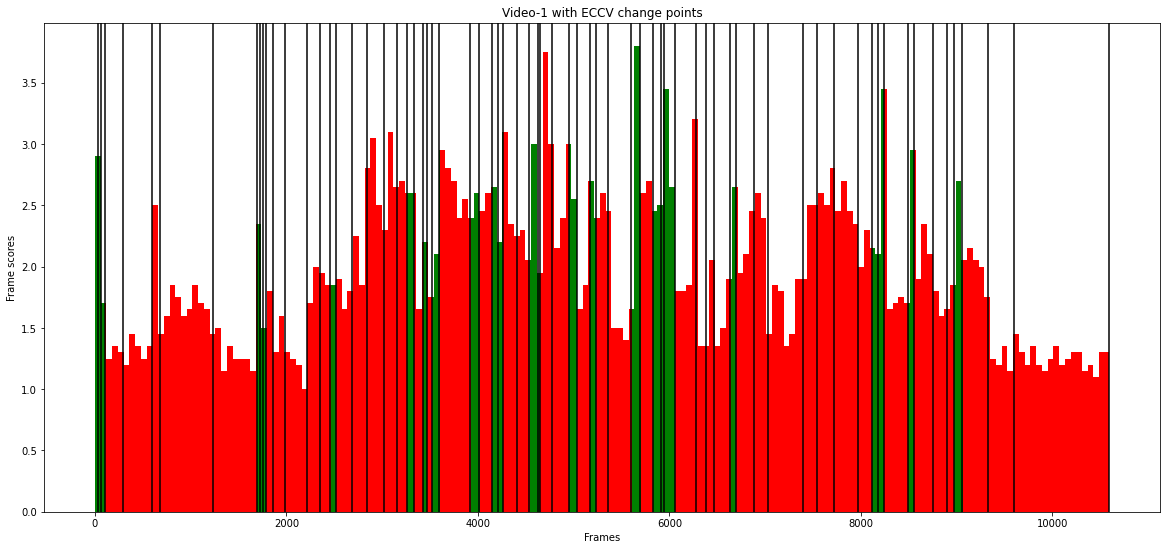

<Figure size 432x288 with 0 Axes>

In [ ]:
fig = plt.figure(figsize = (20, 9))
plt.bar(x=list(range(1, nf+1)), height=gt, width=1, color=color_coding(summary_e))
for s in cp_e:
  plt.axvline(x=s[1], color='black')
plt.xlabel("Frames")
plt.ylabel("Frame scores")
plt.title("Video-"+str(v)+" with ECCV change points")
plt.show()
#plt.savefig("ECCV/"+str(v)+".png")
plt.clf()





> Yahoo



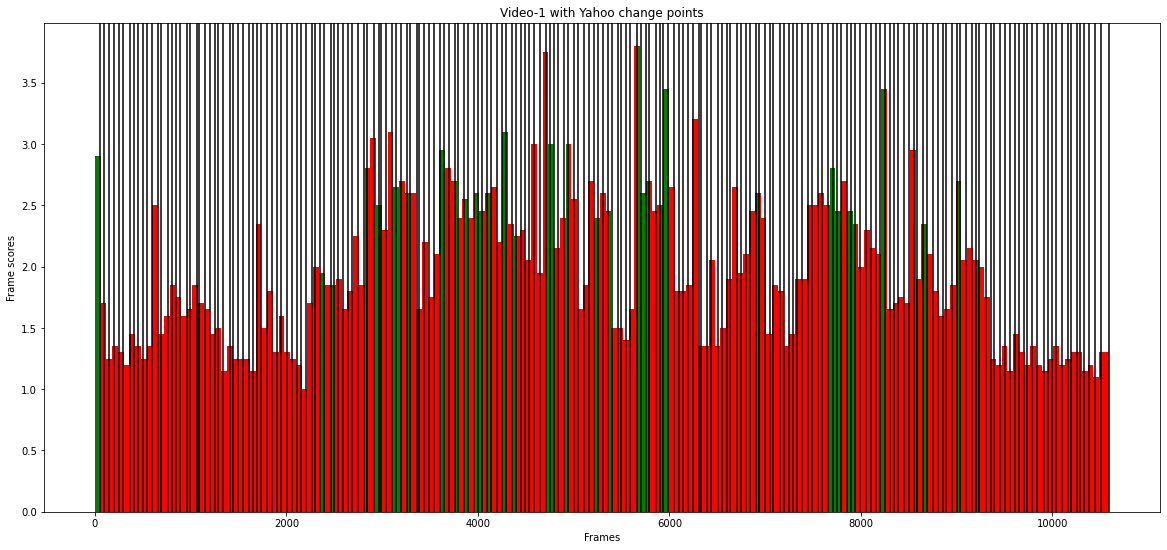

<Figure size 432x288 with 0 Axes>

In [ ]:
fig = plt.figure(figsize = (20, 9))
plt.bar(x=list(range(1, nf+1)), height=gt, width=1, color=color_coding(summary_y))
for s in cp_y:
  plt.axvline(x=s[1], color='black')
plt.xlabel("Frames")
plt.ylabel("Frame scores")
plt.title("Video-"+str(v)+" with Yahoo change points")
plt.show()
#plt.savefig("Yahoo/"+str(v)+".png")
plt.clf()




> New



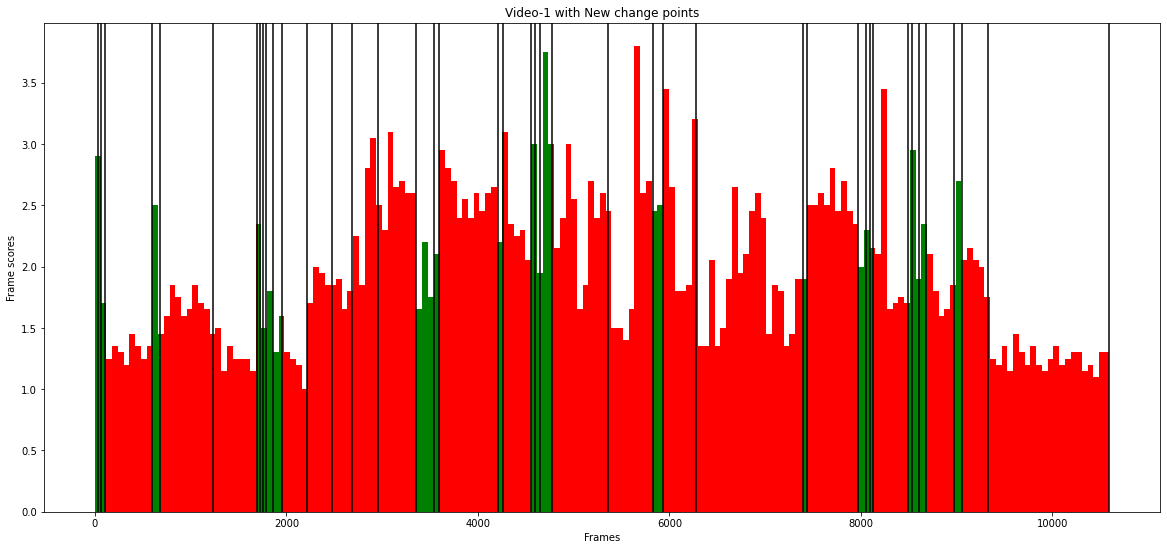

<Figure size 432x288 with 0 Axes>

In [ ]:

fig = plt.figure(figsize = (20, 9))
plt.bar(x=list(range(1, nf+1)), height=gt, width=1, color=color_coding(summary_j))
for s in cp_j:
  plt.axvline(x=s[1], color='black')
plt.xlabel("Frames")
plt.ylabel("Frame scores")
plt.title("Video-"+str(v)+" with New change points")
plt.show()
#plt.savefig("New/"+str(v)+".png")
plt.clf()




> Uniform



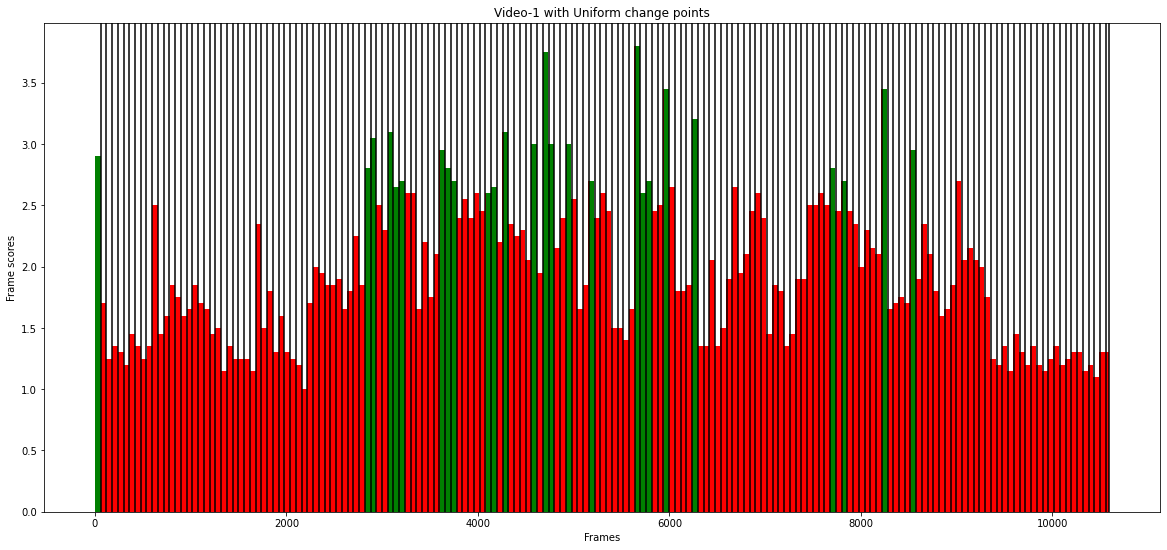

<Figure size 432x288 with 0 Axes>

In [ ]:

fig = plt.figure(figsize = (20, 9))
plt.bar(x=list(range(1, nf+1)), height=gt, width=1, color=color_coding(summary_u))
for s in cp_u:
  plt.axvline(x=s[1], color='black')
plt.xlabel("Frames")
plt.ylabel("Frame scores")
plt.title("Video-"+str(v)+" with Uniform change points")
plt.show()
#plt.savefig("Uniform/"+str(v)+".png")
plt.clf()

# KV-3 (Segment Score V/s Segment Plots)

In [ ]:
def generate_summary3(ypred, cps, n_frames, nfps, positions, proportion=0.15, method='knapsack'):
    """Generate keyshot-based video summary i.e. a binary vector.
    Args:
    ---------------------------------------------
    - ypred: predicted importance scores.
    - cps: change points, 2D matrix, each row contains a segment.
    - n_frames: original number of frames.
    - nfps: number of frames per segment.
    - positions: positions of subsampled frames in the original video.
    - proportion: length of video summary (compared to original video length).
    - method: defines how shots are selected, ['knapsack', 'rank'].
    """
    n_segs = cps.shape[0]
    frame_scores = np.zeros((n_frames), dtype=np.float32)
    if positions.dtype != int:
        positions = positions.astype(np.int32)
    if positions[-1] != n_frames:
        positions = np.concatenate([positions, [n_frames]])
    if len(ypred)==n_frames:
      frame_scores=ypred
    elif len(ypred)==len(positions):
      for i in range(len(positions) - 1):
        pos_left, pos_right = positions[i], positions[i+1]
        if i == len(ypred):
            frame_scores[pos_left:pos_right] = 0
        else:
            frame_scores[pos_left:pos_right] = ypred[i]
    else:
      print("check the length of frame scores")

    seg_score = []
    for seg_idx in range(n_segs):
        start, end = int(cps[seg_idx,0]), int(cps[seg_idx,1]+1)
        scores = frame_scores[start:end]
        seg_score.append(float(scores.mean()))

    limits = int(math.floor(n_frames * proportion))

    if method == 'knapsack':
        #picks = knapsack_dp(seg_score, nfps, n_segs, limits)
        picks = knapsack_ortools(seg_score, nfps, n_segs, limits)
    elif method == 'rank':
        order = np.argsort(seg_score)[::-1].tolist()
        picks = []
        total_len = 0
        for i in order:
            if total_len + nfps[i] < limits:
                picks.append(i)
                total_len += nfps[i]
    else:
        raise KeyError("Unknown method {}".format(method))

    summary = np.zeros((1), dtype=np.float32) # this element should be deleted
    frame_seg_score=[]
    for seg_idx in range(n_segs):
        nf = nfps[seg_idx]
        frame_seg_score.extend([seg_score[seg_idx] for i in range(nf)])
        if seg_idx in picks:
            tmp = np.ones((nf), dtype=np.float32)
        else:
            tmp = np.zeros((nf), dtype=np.float32)
        summary = np.concatenate((summary, tmp))

    summary = np.delete(summary, 0) # delete the first element

    return frame_seg_score, summary


In [ ]:
def color_coding(summary):
  c=[]
  for x in summary:
    if x==0:
      c.append('red')
    elif x==1:
      c.append('green')
  return c


In [ ]:
tvsum_raw=pd.read_excel(excel_path, header=None, sheet_name=str(v)) 
gt=tvsum_raw.mean(axis='columns')

p=tvsum_h5_eccv['video_'+str(v)]['picks'][:]
nf=tvsum_h5_eccv['video_'+str(v)]['n_frames'][()]

cp_e=tvsum_h5_eccv['video_'+str(v)]['change_points'][:]
cp_y=tvsum_cp_y['video_'+str(v)][:]
cp_j=tvsum_cp_j['video_'+str(v)][:]
cp_u=tvsum_cp_u['video_'+str(v)][:]
nfps_e=tvsum_h5_eccv['video_'+str(v)]['n_frame_per_seg'][:]
nfps_y=[]
nfps_j=[]
nfps_u=[]

for y in cp_y:
  nfps_y.append(y[1]-y[0]+1)
nfps_y=np.array(nfps_y)

for j in cp_j:
  nfps_j.append(j[1]-j[0]+1)
nfps_j=np.array(nfps_j)

for u in cp_u:
  nfps_u.append(u[1]-u[0]+1)
nfps_u=np.array(nfps_u)

frame_seg_score_e, summary_e=generate_summary3(gt, cp_e, nf, nfps_e, p)
frame_seg_score_y, summary_y=generate_summary3(gt, cp_y, nf, nfps_y, p)
frame_seg_score_j, summary_j=generate_summary3(gt, cp_j, nf, nfps_j, p)
frame_seg_score_u, summary_u=generate_summary3(gt, cp_u, nf, nfps_u, p)




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Depr

# Plots-KV3



> ECCV



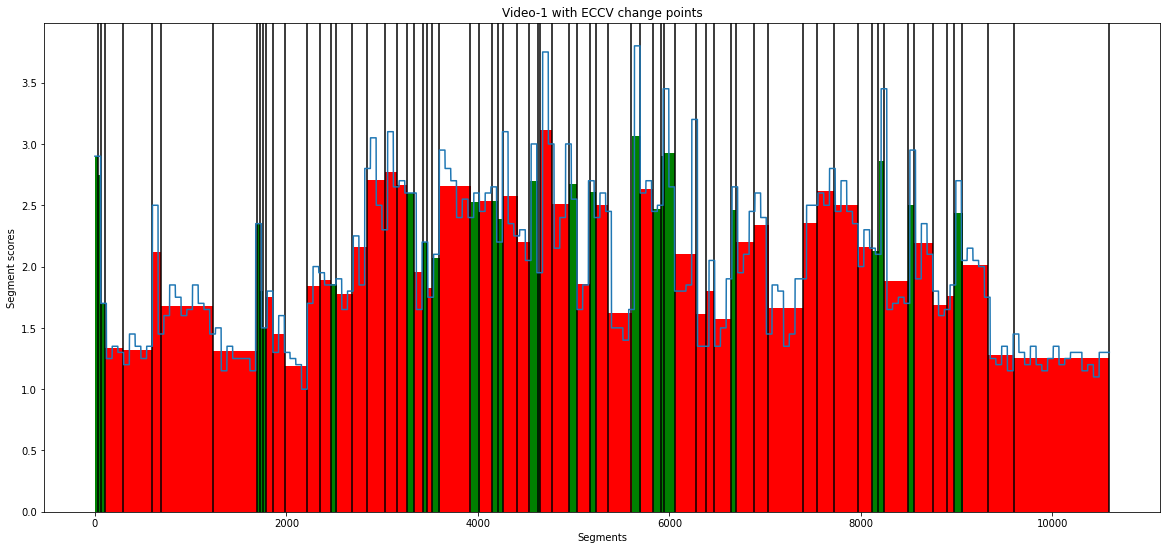

<Figure size 432x288 with 0 Axes>

In [ ]:
fig = plt.figure(figsize = (20, 9))
plt.bar(x=list(range(1, nf+1)), height=frame_seg_score_e, width=1, color=color_coding(summary_e))
for s in cp_e:
  plt.axvline(x=s[1], color='black')
plt.plot(list(range(0, nf)), gt)
plt.xlabel("Segments")
plt.ylabel("Segment scores")
plt.title("Video-"+str(v)+" with ECCV change points")
plt.show()
#plt.savefig("ECCV/"+str(v)+".png")
plt.clf()


In [ ]:
np.array(frame_seg_score_e).shape

(10597,)



> Yahoo



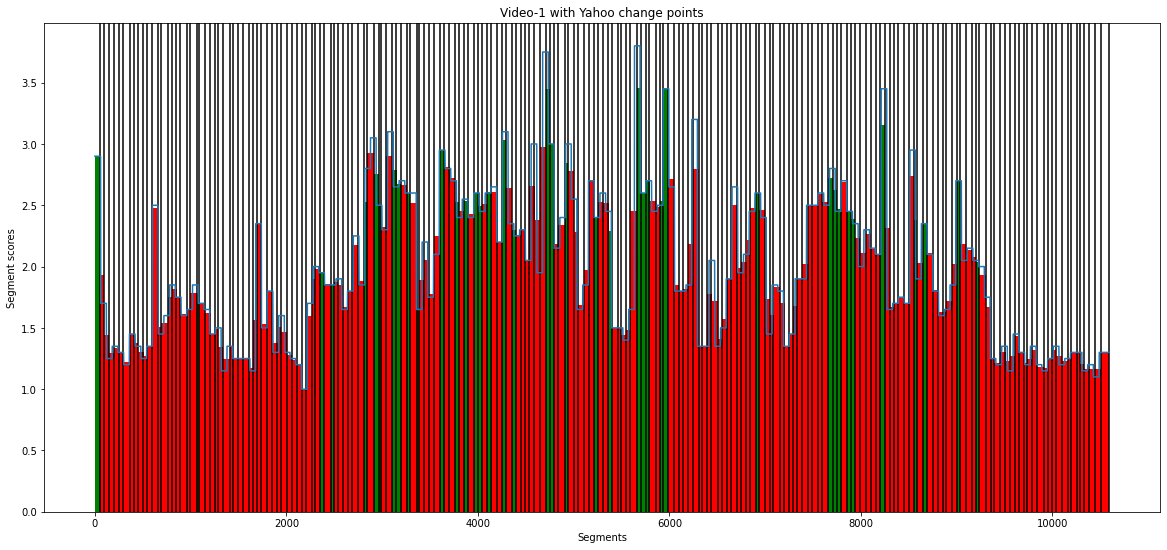

<Figure size 432x288 with 0 Axes>

In [ ]:

fig = plt.figure(figsize = (20, 9))
plt.bar(x=list(range(1, nf+1)), height=frame_seg_score_y, width=1, color=color_coding(summary_y))
for s in cp_y:
  plt.axvline(x=s[1], color='black')
plt.plot(list(range(0, nf)), gt)
plt.xlabel("Segments")
plt.ylabel("Segment scores")
plt.title("Video-"+str(v)+" with Yahoo change points")
plt.show()
#plt.savefig("Yahoo/"+str(v)+".png")
plt.clf()




>New



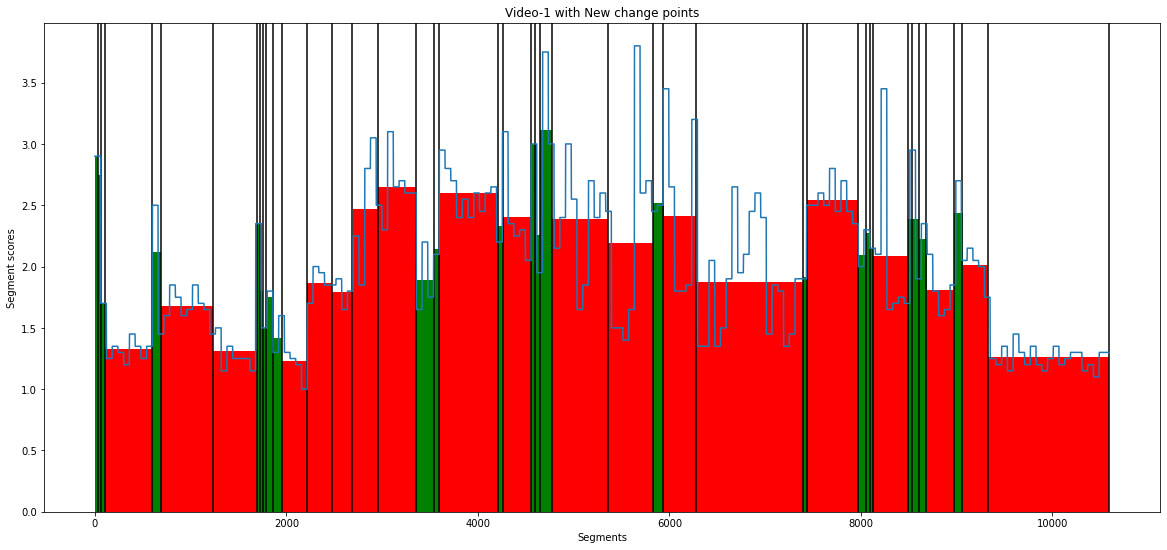

<Figure size 432x288 with 0 Axes>

In [ ]:

fig = plt.figure(figsize = (20, 9))
plt.bar(x=list(range(1, nf+1)), height=frame_seg_score_j, width=1, color=color_coding(summary_j))
for s in cp_j:
  plt.axvline(x=s[1], color='black')
plt.plot(list(range(0, nf)), gt)
plt.xlabel("Segments")
plt.ylabel("Segment scores")
plt.title("Video-"+str(v)+" with New change points")
plt.show()
#plt.savefig("New/"+str(v)+".png")
plt.clf()




> Uniform



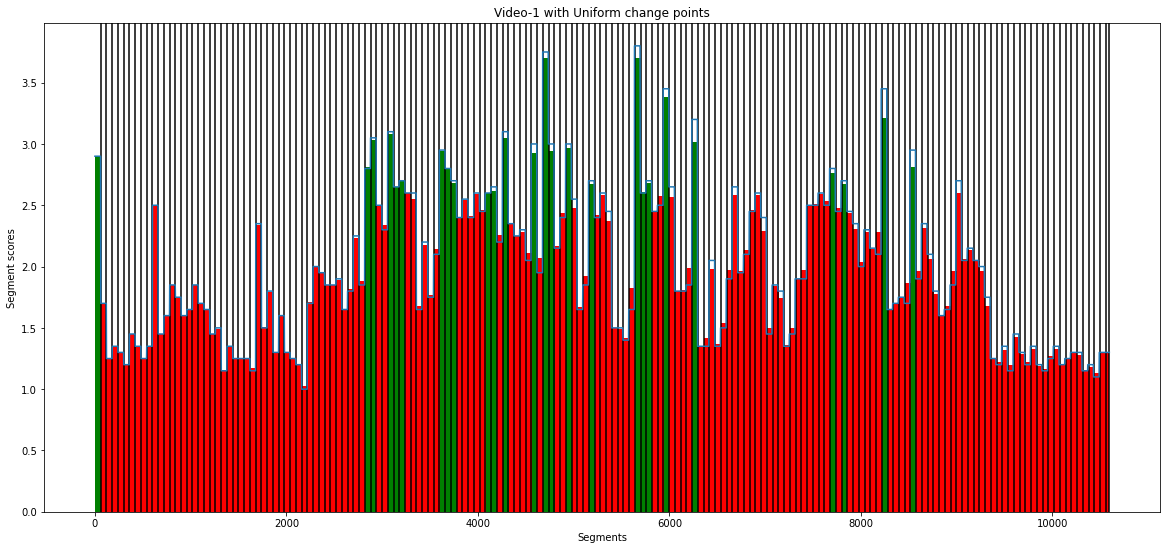

<Figure size 432x288 with 0 Axes>

In [ ]:

fig = plt.figure(figsize = (20, 9))

plt.bar(x=list(range(1, nf+1)), height=frame_seg_score_u, width=1, color=color_coding(summary_u))
for s in cp_u:
  plt.axvline(x=s[1], color='black')
plt.plot(list(range(0, nf)), gt)
plt.xlabel("Segments")
plt.ylabel("Segment scores")
plt.title("Video-"+str(v)+" with Uniform change points")
plt.show()
#plt.savefig("Uniform/"+str(v)+".png")
plt.clf()

  with h5py.File('/content/drive/MyDrive/Feature Extraction - Mabon/feature_analysis/eccv16_dataset_tvsum_google_pool5.h5','r') as hdf:
    f=0
    ky1=np.array(list(hdf.keys()))